In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

c:\Users\Werka\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
@njit
def cross_product(c, d):
    g = np.zeros(3)
    g[0] = c[1]*d[2] - c[2]*d[1]
    g[1] = c[2]*d[0] - c[0]*d[2]
    g[2] = c[0]*d[1] - c[1]*d[0]
    return g

@njit
def wspolczynnik(i, N):
    if i == 0 or i == N:
        return 1
    elif i % 2 == 1:
        return 4
    elif i % 2 == 0:
        return 2

@njit
def calculate_fields(sigma, R, N, M, delta_theta, delta_phi, alpha, L, K):
    # Parametry
    mu_0 = 1
    epsilon_0 = 1
    
    omega = np.array([ np.sin(alpha), np.cos(alpha), 0])

    # Inicjalizacja list do przechowywania wyników
    results = []

    # Iteracja po zakresie x i y
    for x in np.linspace(-L, L, K):
        for y in np.linspace(-L, L, K):
            z = 0
            V = Ex = Ey = Bx = By = 0 # zerowanie zmiennych przed calkowaniem
            
            # *** Całkowanie ***
            for i in range(N+1):
                theta_i = delta_theta * i
                for j in range(M+1):
                    phi_j = delta_phi * j
                    
                    # Obliczanie współrzędnych R'
                    Rx = R * np.sin(theta_i) * np.cos(phi_j)
                    Ry = R * np.sin(theta_i) * np.sin(phi_j)
                    Rz = R * np.cos(theta_i)
                    
                    # Obliczanie odległości i wektora r - r'
                    rr = np.array([x - Rx, y - Ry, z - Rz])
                    rr_len = np.linalg.norm(rr) # fkcja do normy wektorowej
                    
                    # Obliczanie współczynników ai i bj
                    ai = wspolczynnik(i, N)
                    bj = wspolczynnik(j, M)
                    
                    # Obliczanie wartości całki
                    W = sigma * R**2 / (4 * np.pi) * delta_theta * delta_phi / 9
                    V = V +  W * ai * bj * np.sin(theta_i) / rr_len
                    Ex = Ex +  W * ai * bj * np.sin(theta_i) * (x - Rx) / rr_len**3
                    Ey = Ey + W * ai * bj * np.sin(theta_i) * (y - Ry) / rr_len**3
                    
                    # Obliczanie iloczynu wektorowego
                    g1 = cross_product(omega, [Rx, Ry, Rz])
                    g2 = cross_product(rr, g1)
                    
                    Bx = Bx + W * ai * bj * np.sin(theta_i) / (rr_len**3) * g2[0]
                    By = By + W * ai * bj * np.sin(theta_i) / (rr_len**3) * g2[1]
                    
            results.append([x, y, V, Ex, Ey, -Bx, -By])
    
    return results

def V_analytical(yy, sigma, R, epsilon_0, min):
    V = []
    for y in yy:
        if y >= 1:
            V.append( -(sigma * R**2 / epsilon_0) * np.abs(1/y - 1/R) + 1) 
        elif y<= -1:
            V.append( -(sigma * R**2 / epsilon_0) * ( 1/y - 1/R) -1 )
        else: V.append(1)
        #for i, v in enumerate(V):
            #if v>= 1:
                #V[i] = 1
    return V

def plotting_results(results, alpha, save = 0):
    x_vals, y_vals, V_vals, Ex_vals, Ey_vals, Bx_vals, By_vals = zip(*results)
    plt.figure(figsize=(8, 5))
    plt.imshow(np.reshape(V_vals, (K, K)), extent=[np.min(x_vals), np.max(x_vals), np.min(y_vals), np.max(y_vals)], origin='lower')
    plt.colorbar()
    plt.title(f'$V$($x$, $y$)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().add_patch(plt.Circle((0, 0), 1, color='red', fill=False))
    plt.tight_layout()
    if save == 1: plt.savefig(f'{int(4*alpha)}_V_x_y')
    plt.show()

    plt.figure(figsize=(6, 6))
    plt.quiver(np.reshape(x_vals, (K, K)), np.reshape(y_vals, (K, K)), np.reshape(Ex_vals, (K, K)), np.reshape(Ey_vals, (K, K)))
    plt.title('$E$ = [$E_x$, $E_y$]')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().add_patch(plt.Circle((0, 0), 1, color='red', fill=False))
    plt.tight_layout()
    if save == 1: plt.savefig(f'{int(4*alpha)}_E_x_y')
    plt.show()

    plt.figure(figsize=(6, 6))
    plt.quiver(np.reshape(x_vals, (K, K)), np.reshape(y_vals, (K, K)), np.reshape(Bx_vals, (K, K)), np.reshape(By_vals, (K, K)), scale=15)
    if alpha != 0:
        plt.title(f'$B$ = [$B_x$, $B_y$], $\\alpha = \\frac{{\\pi}}{{4}}$')
    else:
        plt.title(f'$B$ = [$B_x$, $B_y$], $\\alpha = 0$')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().add_patch(plt.Circle((0, 0), 1, color='red', fill=False))
    plt.tight_layout()
    if save == 1: plt.savefig(f'{int(4*alpha)}_B_x_y')
    plt.show()

    # Obliczenie wartości V wzdłuż osi y
    
    V_y = np.reshape(V_vals, (K, K))[:,int(K/2)]
    y = np.arange(-3, 3, .01)
    V_analytical_vals = V_analytical(y, 1, 1, 1, np.min(V_y))
    # Rysowanie wykresu V od y
    plt.figure(figsize=(8, 5))
    plt.plot(y, V_analytical_vals, label = 'Analityczne', color = 'firebrick')
    plt.plot(y_vals[1:K-1], V_y[1:-1], label = 'Numeryczne', linestyle = 'dotted', color = 'royalblue', linewidth =4)
    plt.title('$V$(0,$y$,0)')
    plt.xlabel('y')
    plt.ylabel('V')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    if save == 1: plt.savefig(f'{int(4*alpha)}_V_0_y_0')
    plt.show()


# *** Parametry ***
sigma = 1
R = 1
N = M = 201
delta_theta = np.pi / N
delta_phi = 2 * np.pi / M
L = 3.0
K = 41




In [3]:
# Obliczenie pól
alpha = np.pi/4
results = calculate_fields(sigma, R, N, M, delta_theta, delta_phi, alpha, L, K)
x_vals, y_vals, V_vals, Ex_vals, Ey_vals, Bx_vals, By_vals = zip(*results)

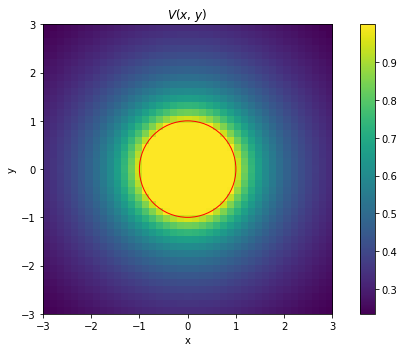

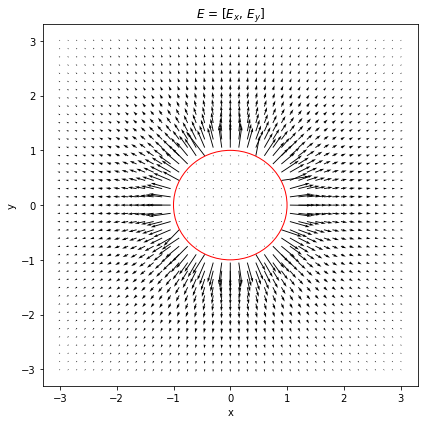

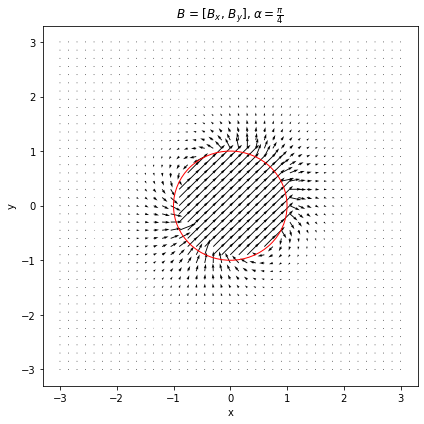

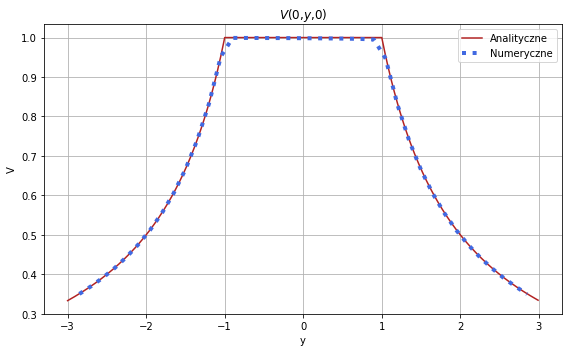

In [4]:
plotting_results(results, alpha, save = 1)

In [5]:
# Obliczenie pól
alpha = 0
results_1 = calculate_fields(sigma, R, N, M, delta_theta, delta_phi, alpha, L, K)
x_vals_1, y_vals_1, V_vals_1, Ex_vals_1, Ey_vals_1, Bx_vals_1, By_vals_1 = zip(*results_1)

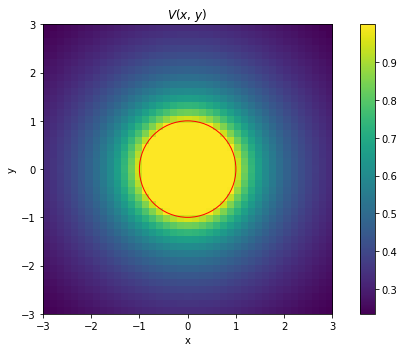

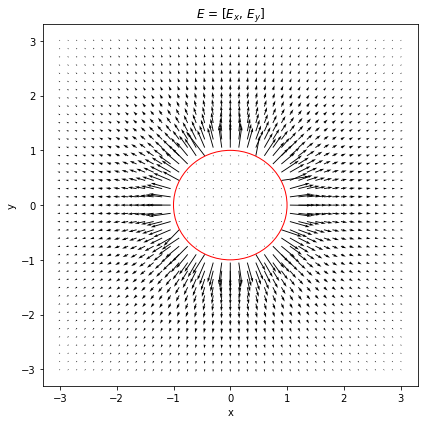

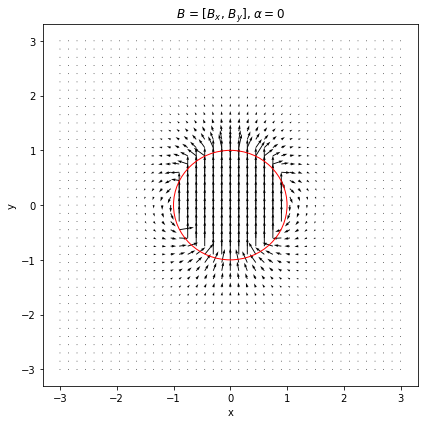

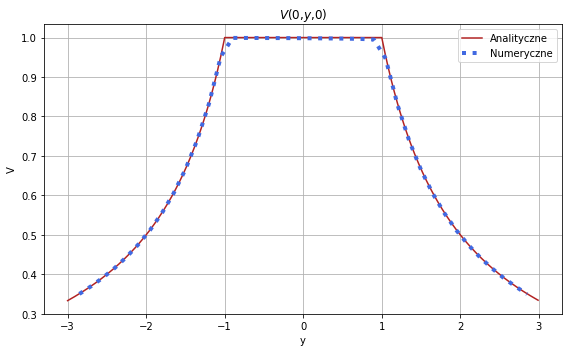

In [6]:
plotting_results(results_1, alpha, save = 1)